In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from bcnf.models.cnf import CondRealNVP_v2
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

from bcnf.train.trainer_data_handler import TrainerDataHandler
from bcnf.train.utils import get_data_type

## Model

In [7]:
BALL_NAME = 'Handball'
BALL = f'Small_{BALL_NAME}'

In [8]:
MODEL_NAME = f'videos_double_CNN_LSTM_large'

In [9]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])
    # config['data']['path'] = sub_root_path(config['data']['path']).replace('/train', '/test')
    config['data']['path'] = os.path.join(get_dir('data', 'bcnf-data', 'Videos', BALL), f'{BALL}.pkl')
    print(config['data']['path'])

cnf = CondRealNVP_v2.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Handball/Small_Handball.pkl
Example camera input size: torch.Size([1, 1, 90, 160])
Output size after first layer: torch.Size([1, 5, 45, 80])
Output size after layer 1: torch.Size([1, 10, 22, 40])
Output size after layer 2: torch.Size([1, 15, 10, 19])
Final output size: 5700
ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.25, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

<All keys matched successfully>

In [10]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 57,355,414


In [11]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [12]:
T = 10
dt = 1/15

In [13]:
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='videos')
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')
data = load_data(
    os.path.join(get_dir('data', 'bcnf-data', 'Videos', BALL), f'{BALL}.pkl'),
    verbose=True,
    keep_output_type='videos',
    errors='ignore')


y, conditions = TrainerDataHandler().get_data_for_training(
    config,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    errors='ignore',
    verbose=True,
    return_tensor_dataset=False)

print(f'{y.shape=}')
for condition in conditions:
    print(f'{condition.shape=}')

Loading data from file...
Found key "cams" in file "<_io.BufferedReader name='/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Handball/Small_Handball.pkl'>". Renaming to "videos".
Loading data from /home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Handball/Small_Handball.pkl...
Loading data from file...
Found key "cams" in file "<_io.BufferedReader name='/home/psaegert/Projects/bcnf/data/bcnf-data/Videos/Small_Handball/Small_Handball.pkl'>". Renaming to "videos".
Using videos data for training. Shapes:
Conditions: [torch.Size([1, 2, 30, 90, 160]), torch.Size([1, 7])]
Parameters: torch.Size([1, 19])
y.shape=torch.Size([1, 19])
condition.shape=torch.Size([1, 2, 30, 90, 160])
condition.shape=torch.Size([1, 7])


## Resimulation

In [14]:
data['g_z'] = data.pop('g')
data['g_x'] = np.zeros_like(data['g_z'])
data['g_y'] = np.zeros_like(data['g_z'])

In [ ]:
# https://github.com/scipy/scipy/issues/15940
# When unexpectedly slow, check if the videos have been loaded instead of trajectories
X_resimulation = resimulate(
    cnf,
    T * 10,
    dt,
    data,
    None,
    *conditions,
    m_samples=10_000,
    batch_size=32,
    break_on_impact=True,
    n_procs=32
)

In [16]:
X_resimulation.shape

(1, 10000, 1500, 3)

In [17]:
X = conditions[0].cpu().numpy()

In [18]:
X.shape

(1, 2, 30, 90, 160)

## Impact

In [19]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [20]:
true_impact_indices = np.where(np.diff((X[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X[true_impact_indices[0], true_impact_indices[1]]

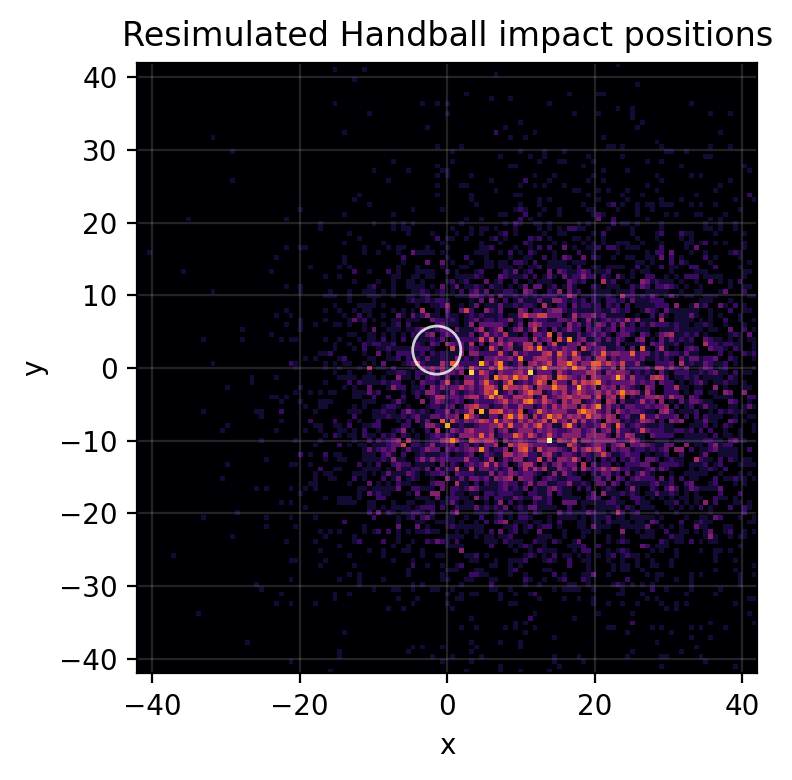

In [21]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(4, 4),  dpi=200)

ax.hist2d(X_resimulation_impact_positions[0][:, 0], X_resimulation_impact_positions[0][:, 1], bins=np.linspace(-42, 42, 128), cmap='inferno');
ax.scatter(data['poi'][0][0], data['poi'][0][1], s=300, marker='o', label='True impact', facecolors='none', edgecolors='white', alpha=0.8);

ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title(f'Resimulated {BALL_NAME} impact positions');

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'irl', 'figures', create=True), f'resimulation_impact_heatmap_{BALL}.png'))

## Resimulations

In [22]:
X_resimulation.shape

(1, 10000, 1500, 3)

In [23]:
data.keys()

dict_keys(['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'w_x', 'w_y', 'w_z', 'b', 'A', 'Cd', 'rho', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian', 'r', 'cam_radius', 'cam_angles', 'cam_heights', 'poi', 'videos', 'g_z', 'g_x', 'g_y'])

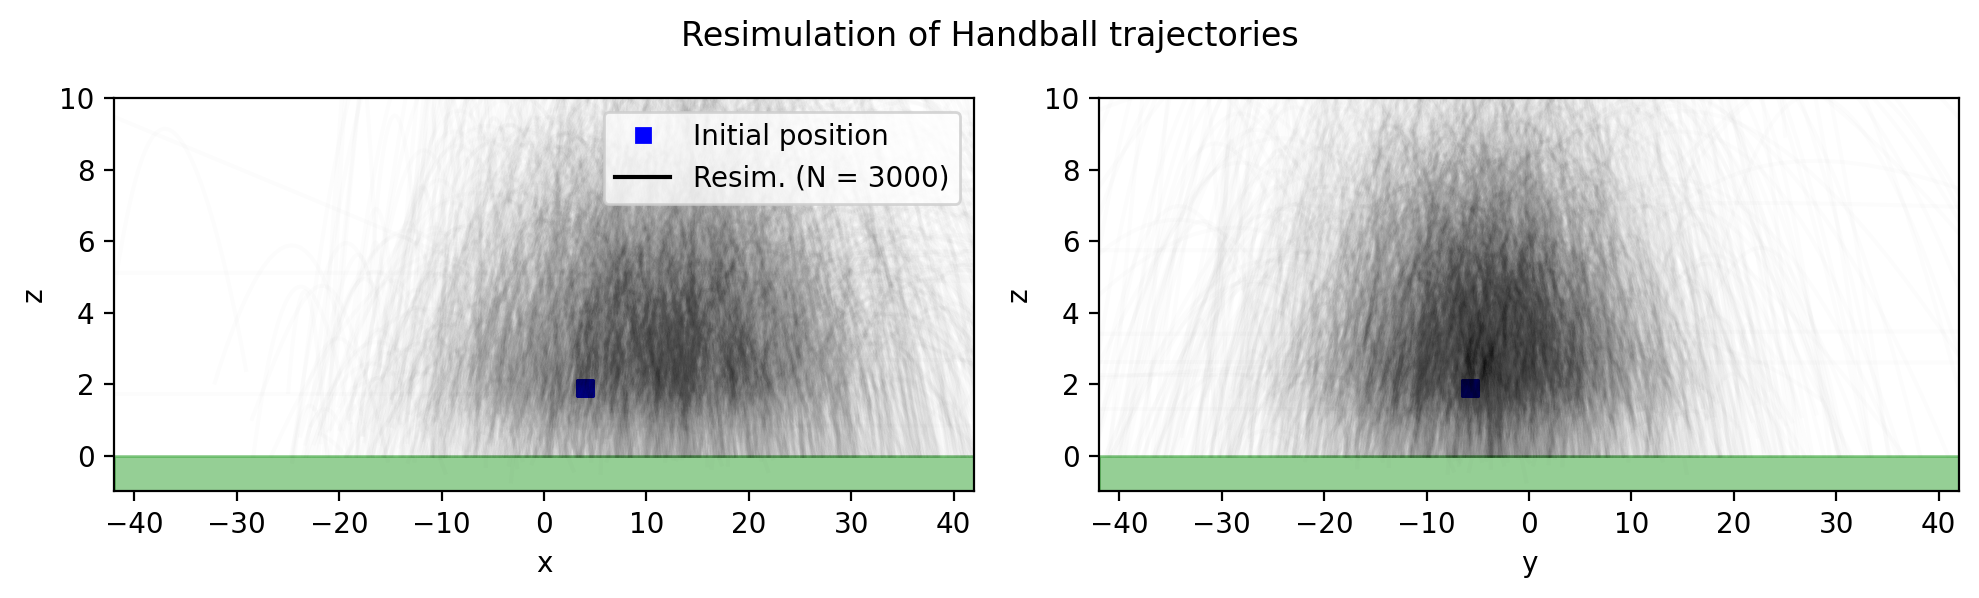

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=200)

n_trajectories = 3000
max_time = 1000

for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[0, :n_trajectories, :max_time, i].T, X_resimulation[0, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
    # ax.plot(X[0, :, i], X[0, :, 2], label='Ground Truth', color='red', linewidth=1);
    # ax.plot(X[0, -1, i], X[0, -1, 2], marker='o', markersize=2, color='red');

    ax.scatter(data[f'x0_{ax_name}'], data[f'x0_z'], marker='s', label='Initial position', color='blue');

    ax.set_xlim(-42, 42)
    ax.set_ylim(-1, 10)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.axhspan(-2, 0, alpha=0.5, color='tab:green');

# Add an additional legend for resimulation with red and black lines
black_patch = plt.Line2D([0], [0], color='black', label=f'Resim. (N = {n_trajectories})')
blue_patch = plt.Line2D([0], [0], color='blue', label='Initial position', marker='s', markersize=5, linestyle='None')
axes[0].legend(handles=[blue_patch, black_patch], loc='upper right');

fig.tight_layout()

fig.suptitle(f'Resimulation of {BALL_NAME} trajectories')
fig.subplots_adjust(top=0.85)

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'irl', 'figures', create=True), f'resimulation_{BALL}.png'), dpi=200)

In [56]:
# Compute the error with regards to the point of impact: Compute the median distance of the resimulation impact position to the true impact position
impact_errors = [np.array([np.linalg.norm(X_resimulation_impact_positions[j] - X_val_impact_position, axis=1)]) for j, X_val_impact_position in zip(true_impact_indices[0], X_val_impact_positions)]

In [ ]:
median_impact_errors = np.array([np.nanmedian(impact_error, axis=1) for impact_error in impact_errors])

/home/psaegert/miniconda3/envs/bcnf/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
np.nanmedian(median_impact_errors)

1.182460558066636

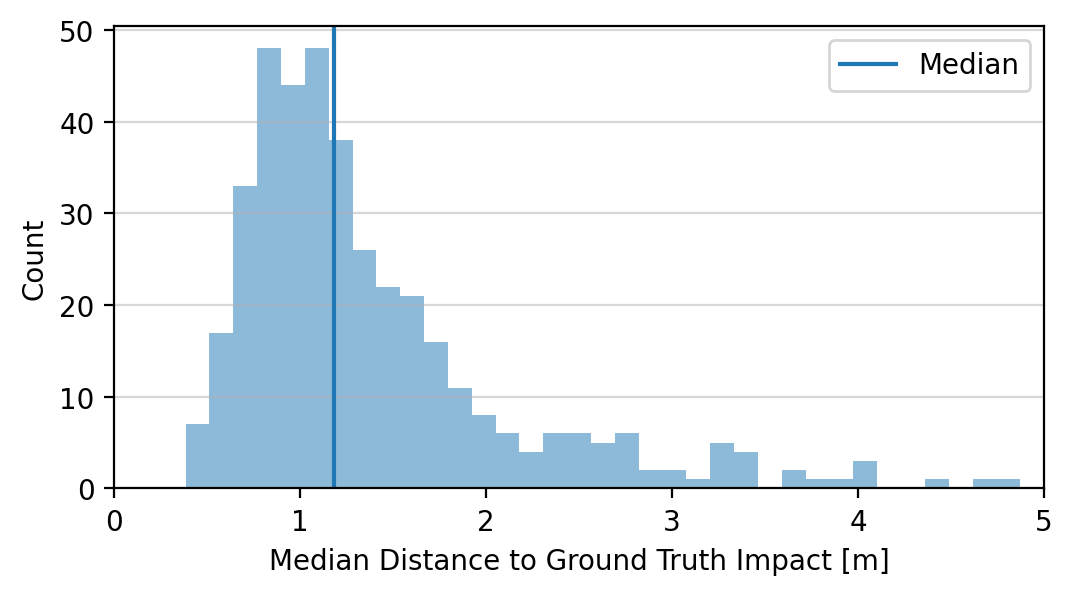

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)

ax.hist(median_impact_errors.flatten(), bins=np.linspace(0, 5, 40), alpha=0.5);
ax.set_xlim(0, 5)
ax.axvline(np.nanmedian(median_impact_errors), color='C0', label='Median')

ax.set_xlabel('Median Distance to Ground Truth Impact [m]')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.5)
ax.legend();

# plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'impact_error.png'), dpi=200, bbox_inches='tight')

## Calcualate model score

### Trajectory

In [ ]:
X_error_copy_perm = X_error_copy.transpose(1, 0, 2, 3)
print(f'{X_error_copy_perm.shape=}')

X_error_copy_perm.shape=(1000, 100, 30, 3)


In [ ]:
error_traj = np.median(X_error_copy_perm, axis=(1, 2, 3))
print(f'{error_traj.shape=}')

error_traj.shape=(1000,)


Number of elements in error_traj:  1000 Number of elements in error_traj_mod:  1000
Mean trajectory error:  44.945


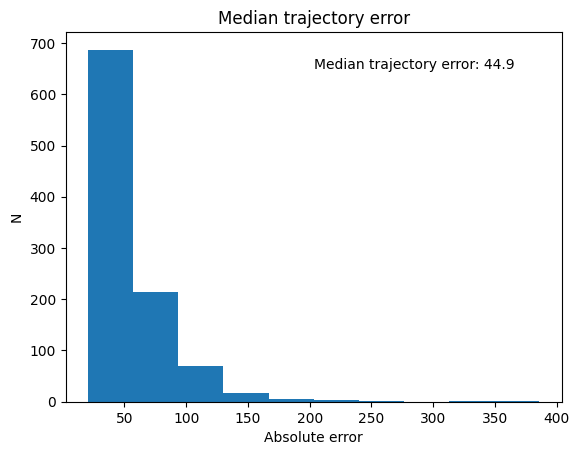

In [ ]:
error_traj_mod = error_traj[error_traj < 1e20]
print("Number of elements in error_traj: ", len(error_traj), "Number of elements in error_traj_mod: ", len(error_traj_mod))
error_tot_traj = round(np.median(error_traj_mod),3)
print("Mean trajectory error: ", error_tot_traj)

plt.hist(error_traj_mod, bins=10)
plt.xlabel('Absolute error')
plt.ylabel('N')
plt.text(0.5, 0.9, f"Median trajectory error: {error_tot_traj:.3}", transform=plt.gca().transAxes)
plt.title('Median trajectory error')
plt.show()


### Impact - BROKEN AHHHHHHHHHHHHHHHHHh i am going crazy

In [ ]:
X_resimulation_perm = X_resimulation.transpose(1, 0, 2, 3)
print(f'{X_resimulation_perm.shape=}')

X_resimulation_perm.shape=(1000, 100, 30, 3)


In [ ]:
impact_indices = [np.where(np.diff((X_resimulation_perm[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation_perm.shape[0])]

In [ ]:
mean_impact = np.zeros((len(impact_indices), 2))

for sim_num in range(len(impact_indices)):
    for i in range(len(impact_indices[sim_num][0])):
        mean_impact[sim_num, 0] += impact_indices[sim_num][0][i]
        mean_impact[sim_num, 1] += impact_indices[sim_num][1][i]

    mean_impact[sim_num, 0] /= len(impact_indices[sim_num][0])
    mean_impact[sim_num, 1] /= len(impact_indices[sim_num][1])

print(f'{mean_impact.shape=}')

mean_impact.shape=(1000, 2)


In [ ]:
X_trajectories[22][29]

array([ -0.79738716, -15.11917101,   3.29766588])

In [ ]:
def find_sign_change_idx(sample):
    for i in range(len(sample) - 1):
        if sample[i][2] > 0 and sample[i + 1][2] < 0:
            return i
        
    print("FUCK")
    return None

In [ ]:
coordinates = []

for sample in X_trajectories:
    idx = find_sign_change_idx(sample)
    if idx is not None:
        x, y, _ = sample[idx]  # Extracting x and y coordinates
        coordinates.append((x, y))

FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK


In [ ]:
print(f'{len(coordinates)=}')

len(coordinates)=21


In [ ]:
true_impact_indices = np.where(np.diff((X_trajectories[:, :, -1] > 0).astype(int)) == -1)
print(f'{len(true_impact_indices)=}')
print(f'{type(true_impact_indices[0])=}')
print(f'{true_impact_indices[0].shape=}')

len(true_impact_indices)=2
type(true_impact_indices[0])=<class 'numpy.ndarray'>
true_impact_indices[0].shape=(403,)


In [ ]:
X_val_impact_positions = X_trajectories[true_impact_indices[0], true_impact_indices[1]]
print(f'{X_val_impact_positions.shape=}')
print(f'{X_val_impact_positions[0].shape=}')

X_val_impact_positions.shape=(403, 3)
X_val_impact_positions[0].shape=(3,)
